# Machine Learning Model Architecture

## Construction of Test/Train datasets

In [ ]:
import pandas as pd
# Let's make sure these directories are clean before we start
import shutil
try:
    shutil.rmtree("../data/project3/data_all_modified/data_split/train")
    shutil.rmtree("../data/project3/data_all_modified/data_split/test")
except:
    pass

In [2]:
# We have two classes which contains all the data: Damage & No_damage
# Let's create directories for each class in the train and test directories.
import os
# ensure directories exist
from pathlib import Path

Path("../data/project3/data_all_modified/data_split/test/damage").mkdir(parents=True, exist_ok=True)
Path("../data/project3/data_all_modified/data_split/test/no_damage").mkdir(parents=True, exist_ok=True)

Path("../data/project3/data_all_modified/data_split/train/damage").mkdir(parents=True, exist_ok=True)
Path("../data/project3/data_all_modified/data_split/train/no_damage").mkdir(parents=True, exist_ok=True)

In [3]:
# we need paths of images for individual classes so we can copy them in the new directories that we created above
all_damage_file_paths = os.listdir('../data/project3/data_all_modified/damage')
all_no_damage_file_paths = os.listdir('../data/project3/data_all_modified/no_damage')

In [4]:
import random

train_damage_paths = random.sample(all_damage_file_paths, int(len(all_damage_file_paths)*0.8))
print("train Damage image count: ", len(train_damage_paths))
test_damage_paths = [ p for p in all_damage_file_paths if p not in train_damage_paths]
print("test Damage image count: ", len(test_damage_paths))
# ensure no overlap:
overlap = [p for p in train_damage_paths if p in test_damage_paths]
print("len of overlap: ", len(overlap))

train_no_damage_paths = random.sample(all_no_damage_file_paths, int(len(all_no_damage_file_paths)*0.8))
print("train No Damage image count: ", len(train_no_damage_paths))
test_no_damage_paths = [ p for p in all_no_damage_file_paths if p not in train_no_damage_paths]
print("test No Damage image count: ", len(test_no_damage_paths))
# ensure no overlap:
overlap = [p for p in train_no_damage_paths if p in test_no_damage_paths]
print("len of overlap: ", len(overlap))

train Damage image count:  11336
test Damage image count:  2834
len of overlap:  0
train No Damage image count:  5721
test No Damage image count:  1431
len of overlap:  0


In [5]:
#ensure to copy the images to the directories
import shutil
for p in train_damage_paths:
    shutil.copyfile(os.path.join('../data/project3/data_all_modified/damage', p), os.path.join("../data/project3/data_all_modified/data_split/train/damage", p) )

for p in test_damage_paths:
    shutil.copyfile(os.path.join('../data/project3/data_all_modified/damage', p), os.path.join("../data/project3/data_all_modified/data_split/test/damage", p) )

for p in train_no_damage_paths:
    shutil.copyfile(os.path.join('../data/project3/data_all_modified/no_damage', p), os.path.join("../data/project3/data_all_modified/data_split/train/no_damage", p) )

for p in test_no_damage_paths:
    shutil.copyfile(os.path.join('../data/project3/data_all_modified/no_damage', p), os.path.join("../data/project3/data_all_modified/data_split/test/no_damage", p) )

# check counts:
print("Files in train/damage: ", len(os.listdir("../data/project3/data_all_modified/data_split/train/damage")))
print("Files in train/no_damage: ", len(os.listdir("../data/project3/data_all_modified/data_split/test/damage")))

print("Files in test/damage: ", len(os.listdir("../data/project3/data_all_modified/data_split/train/no_damage")))
print("Files in test/no_damage: ", len(os.listdir("../data/project3/data_all_modified/data_split/test/no_damage")))

Files in train/damage:  11336
Files in train/no_damage:  2834
Files in test/damage:  5721
Files in test/no_damage:  1431


## Data Pre-Processing

In [6]:
# Using PIL to get image dimensions
# Chat GPT helped in debugging the check image size function, especially with adding the dimensions to storage
from PIL import Image

def get_image_dimensions(image_path: str):
    '''
    Gets image dimensions through the input of a directory

    Input: Takes string input of the directory path to an image

    Output: Returns image dimensions of height & width pixels
    '''
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            return width, height
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

def check_images_same_size(directory: str):
    '''
    Ensures that all images within a directory are the same size

    Input: Takes a string input of the desired directory to be check

    Output: Prints a statement stating images are the same size & their dimensions,
            or prints that the images have different sizes, or that there werent any valid images in
            the directory.
    '''
    dimensions_set = set()  # To store unique dimensions of images
    for filename in os.listdir(directory):
        if filename.endswith(".jpeg"):
            image_path = os.path.join(directory, filename)
            dimensions = get_image_dimensions(image_path)
            if dimensions:
                dimensions_set.add(dimensions)

    if len(dimensions_set) == 1:
        dimensions = dimensions_set.pop()
        print("All images are the same size.")
        print(f"Image dimensions: {dimensions[0]}x{dimensions[1]} pixels")
    elif len(dimensions_set) > 1:
        print("Images have different sizes.")
    else:
        print("No valid images found in the directory.")

In [7]:
train_data_dmg = '../data/project3/data_all_modified/data_split/train/damage'
train_data_no_dmg = '../data/project3/data_all_modified/data_split/train/no_damage'
check_images_same_size(train_data_dmg)
check_images_same_size(train_data_no_dmg)

All images are the same size.
Image dimensions: 128x128 pixels
All images are the same size.
Image dimensions: 128x128 pixels


In [8]:
#pip install tensorflow_datasets --user

In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import layers, models, optimizers
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
# Now that we know the image dimensions
train_data_dir = '../data/project3/data_all_modified/data_split/train'
# Number of images we want to process at once
batch_size = 64

# Target image size (128 px by 128 px)
img_height = 128
img_width = 128
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
train_data_dir,
validation_split=0.2,
subset="both",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size
)
rescale = Rescaling(scale=1.0/255)
train_rescale_ds = train_ds.map(lambda image,label:(rescale(image),label))
val_rescale_ds = val_ds.map(lambda image,label:(rescale(image),label))

Found 17057 files belonging to 2 classes.
Using 13646 files for training.
Using 3411 files for validation.


In [10]:
test_data_dir = '../data/project3/data_all_modified/data_split/test'

batch_size = 2

img_height = 128
img_width = 128

# note that subset="training", "validation", "both", and dictates what is returned
test_ds = tf.keras.utils.image_dataset_from_directory(
test_data_dir,
seed=123,
image_size=(img_height, img_width),
)

rescale = Rescaling(scale=1.0/255)
test_rescale_ds = test_ds.map(lambda image,label:(rescale(image),label))

Found 4265 files belonging to 2 classes.


## A Dense ANN Model

In [11]:
# Building a CNN with 3 alternating convolutional layers & pooling layers
# with 2 dense hidden layers. Output layer has 3 classes & softmax activation

dimen = img_height * img_width * 3

# initialize sequential model
model_ann = models.Sequential()

# Flattening of input data for the dense layers
model_ann.add(layers.Flatten(input_shape = (img_height,img_width,3)))

# Adding inital dense layer with 256 perceptrons
model_ann.add(layers.Dense(256, activation = 'relu'))

# Adding a fully connected dense layer with 128 perceptrons
model_ann.add(layers.Dense(128, activation='relu'))

# Adding a fully connected dense layer with 64 perceptrons
model_ann.add(layers.Dense(64, activation='relu'))

# Adding a fully connected dense layer with 32 perceptrons
model_ann.add(layers.Dense(32, activation='relu'))

# Adding a fully connected dense layer with 16 perceptrons
model_ann.add(layers.Dense(16, activation='relu'))

# Adding a fully connected dense layer with 8 perceptrons
model_ann.add(layers.Dense(8, activation='relu'))

# Adding the output layer with 2 neuron and 
# activation functions as sigmoid since this is a binary classification problem
model_ann.add(layers.Dense(2, activation='sigmoid'))

In [12]:
# Compile model
# RMSprop (Root Mean Square Propagation) is commonly used in training deep neural networks.
model_ann.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

# Generating the summary of the model
model_ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 256)               12583168  
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 8)                 1

In [13]:
#fit the model from image generator
history = model_ann.fit(
            train_rescale_ds,
            batch_size=64,
            epochs= 30,
            validation_data=val_rescale_ds
)

Epoch 1/30
214/214 [==============================] - 16s 68ms/step - loss: 0.6419 - accuracy: 0.6637 - val_loss: 0.6514 - val_accuracy: 0.6681
Epoch 2/30
214/214 [==============================] - 16s 74ms/step - loss: 0.6215 - accuracy: 0.6637 - val_loss: 0.6682 - val_accuracy: 0.6681
Epoch 3/30
214/214 [==============================] - 17s 77ms/step - loss: 0.6042 - accuracy: 0.6637 - val_loss: 0.6163 - val_accuracy: 0.6681
Epoch 4/30
214/214 [==============================] - 16s 74ms/step - loss: 0.5937 - accuracy: 0.6637 - val_loss: 0.5768 - val_accuracy: 0.6681
Epoch 5/30
214/214 [==============================] - 16s 73ms/step - loss: 0.5865 - accuracy: 0.6637 - val_loss: 0.6145 - val_accuracy: 0.6681
Epoch 6/30
214/214 [==============================] - 16s 75ms/step - loss: 0.5838 - accuracy: 0.6877 - val_loss: 0.5954 - val_accuracy: 0.6746
Epoch 7/30
214/214 [==============================] - 16s 75ms/step - loss: 0.5802 - accuracy: 0.7214 - val_loss: 0.5669 - val_accuracy:

In [14]:
test_loss, test_accuracy = model_ann.evaluate(test_rescale_ds, verbose = 0)
# validation accuracy
print(f'Test Loss: {test_loss}')
# test accuracy
print(f'Test Accuracy: {test_accuracy}')

Test Loss: 0.6389994621276855
Test Accuracy: 0.7193434834480286


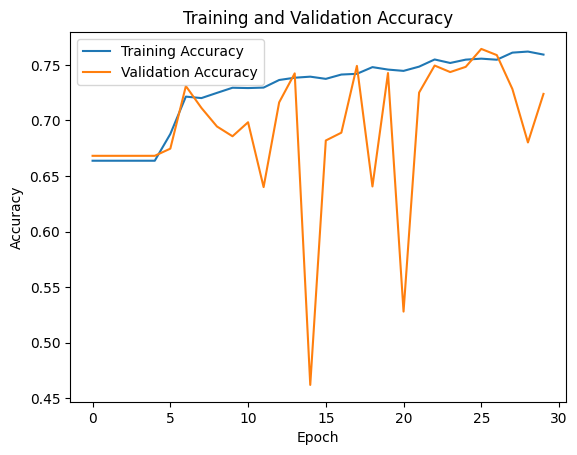

In [31]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## LeNet-5 Architecture

In [16]:
model_lenet5 = models.Sequential()

# Layer 1: Convolutional layer with 6 filters of size 3x3, followed by average pooling
model_lenet5.add(layers.Conv2D(6, kernel_size=(3, 3), activation='relu', input_shape=(img_height,img_width,3)))
model_lenet5.add(layers.AveragePooling2D(pool_size=(2, 2)))

# Layer 2: Convolutional layer with 16 filters of size 3x3, followed by average pooling
model_lenet5.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu'))
model_lenet5.add(layers.AveragePooling2D(pool_size=(2, 2)))

# Flatten the feature maps to feed into fully connected layers
model_lenet5.add(layers.Flatten())

# Layer 3: Fully connected layer with 120 neurons
model_lenet5.add(layers.Dense(120, activation='relu'))

# Layer 4: Fully connected layer with 84 neurons
model_lenet5.add(layers.Dense(84, activation='relu'))

# Output layer: Fully connected layer with num_classes neurons (e.g., 1 )
model_lenet5.add(layers.Dense(2, activation='sigmoid'))

# Compile model
model_lenet5.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), 
                     loss='sparse_categorical_crossentropy', 
                     metrics=['accuracy'])

# Generating the summary of the model
model_lenet5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 6)       168       
                                                                 
 average_pooling2d (Average  (None, 63, 63, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 16)        880       
                                                                 
 average_pooling2d_1 (Avera  (None, 30, 30, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten_1 (Flatten)         (None, 14400)             0         
                                                                 
 dense_7 (Dense)             (None, 120)              

In [17]:
history2 = model_lenet5.fit(
            train_rescale_ds,
            batch_size=64,
            epochs=30,
            validation_data=val_rescale_ds
)

Epoch 1/30
214/214 [==============================] - 23s 102ms/step - loss: 0.6338 - accuracy: 0.6662 - val_loss: 0.6282 - val_accuracy: 0.7291
Epoch 2/30
214/214 [==============================] - 21s 100ms/step - loss: 0.5841 - accuracy: 0.7083 - val_loss: 0.6103 - val_accuracy: 0.6737
Epoch 3/30
214/214 [==============================] - 21s 99ms/step - loss: 0.5341 - accuracy: 0.7465 - val_loss: 0.6334 - val_accuracy: 0.6834
Epoch 4/30
214/214 [==============================] - 21s 99ms/step - loss: 0.4929 - accuracy: 0.7854 - val_loss: 0.4770 - val_accuracy: 0.7704
Epoch 5/30
214/214 [==============================] - 22s 102ms/step - loss: 0.4647 - accuracy: 0.8025 - val_loss: 0.4469 - val_accuracy: 0.7992
Epoch 6/30
214/214 [==============================] - 21s 99ms/step - loss: 0.4484 - accuracy: 0.8134 - val_loss: 0.4570 - val_accuracy: 0.7883
Epoch 7/30
214/214 [==============================] - 21s 100ms/step - loss: 0.4336 - accuracy: 0.8203 - val_loss: 0.3963 - val_accur

In [18]:
test_loss, test_accuracy = model_lenet5.evaluate(test_rescale_ds, verbose = 0)
# validation accuracy
print(f'Test Loss: {test_loss}')
# test accuracy
print(f'Test Accuracy: {test_accuracy}')

Test Loss: 0.23854883015155792
Test Accuracy: 0.9005861878395081


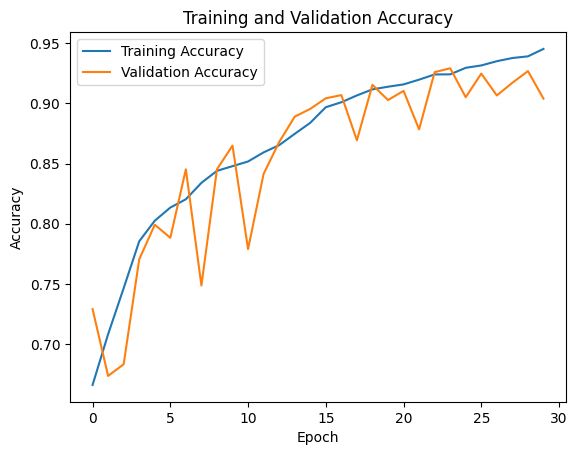

In [30]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## Modified LeNet-5

In [22]:
from keras import layers
from keras import models
import pandas as pd

model_mod_lenet5 = models.Sequential()
# Layer 1: Convolutional layer with 6 filters of size 3x3, followed by Max pooling
model_mod_lenet5.add(layers.Conv2D(6, kernel_size=(3, 3), activation='relu', input_shape=(img_height,img_width,3)))
model_mod_lenet5.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Layer 2: Convolutional layer with 32 filters of size 3x3, followed by Max pooling
model_mod_lenet5.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_height,img_width,3)))
model_mod_lenet5.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Layer 3: Convolutional layer with 64 filters of size 3x3, followed by Max pooling
model_mod_lenet5.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(img_height,img_width,3)))
model_mod_lenet5.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Layer 4: Convolutional layer with 128 filters of size 3x3, followed by Max pooling
model_mod_lenet5.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(img_height,img_width,3)))
model_mod_lenet5.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Layer 5: Convolutional layer with 128 filters of size 3x3, followed by Max pooling
model_mod_lenet5.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(img_height,img_width,3)))
model_mod_lenet5.add(layers.MaxPooling2D(pool_size=(2, 2)))
# flattening the output of the conv layer after max pooling 
model_mod_lenet5.add(layers.Flatten())
#Dropout Layer
model_mod_lenet5.add(layers.Dropout(0.2))
# Layer 8: Fully connected layer with 120 neurons
model_mod_lenet5.add(layers.Dense(512, activation='relu'))

model_mod_lenet5.add(layers.Dense(2, activation='sigmoid'))

model_mod_lenet5.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), 
                     loss='sparse_categorical_crossentropy', 
                     metrics=['accuracy'])

# Generating the summary of the model
model_mod_lenet5.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 126, 126, 6)       168       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 63, 63, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 61, 61, 32)        1760      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 14, 14, 64)       

In [23]:
history3 = model_mod_lenet5.fit(
            train_rescale_ds,
            batch_size=64,
            epochs=30,
            validation_data=val_rescale_ds
)

Epoch 1/30
214/214 [==============================] - 34s 149ms/step - loss: 0.5862 - accuracy: 0.7087 - val_loss: 0.4916 - val_accuracy: 0.8218
Epoch 2/30
214/214 [==============================] - 31s 146ms/step - loss: 0.4681 - accuracy: 0.7947 - val_loss: 0.4194 - val_accuracy: 0.8097
Epoch 3/30
214/214 [==============================] - 32s 147ms/step - loss: 0.4285 - accuracy: 0.8188 - val_loss: 0.3728 - val_accuracy: 0.8414
Epoch 4/30
214/214 [==============================] - 32s 148ms/step - loss: 0.4003 - accuracy: 0.8312 - val_loss: 0.3535 - val_accuracy: 0.8514
Epoch 5/30
214/214 [==============================] - 32s 148ms/step - loss: 0.3768 - accuracy: 0.8464 - val_loss: 0.3391 - val_accuracy: 0.8558
Epoch 6/30
214/214 [==============================] - 32s 150ms/step - loss: 0.3564 - accuracy: 0.8519 - val_loss: 0.3349 - val_accuracy: 0.8622
Epoch 7/30
214/214 [==============================] - 31s 146ms/step - loss: 0.3370 - accuracy: 0.8600 - val_loss: 0.3101 - val_ac

In [24]:
mod_test_loss, test_accuracy = model_mod_lenet5.evaluate(test_rescale_ds, verbose = 0)
# validation accuracy
print(f'Test Loss: {mod_test_loss}')
# test accuracy
print(f'Test Accuracy: {test_accuracy}')

Test Loss: 0.20942941308021545
Test Accuracy: 0.912309467792511


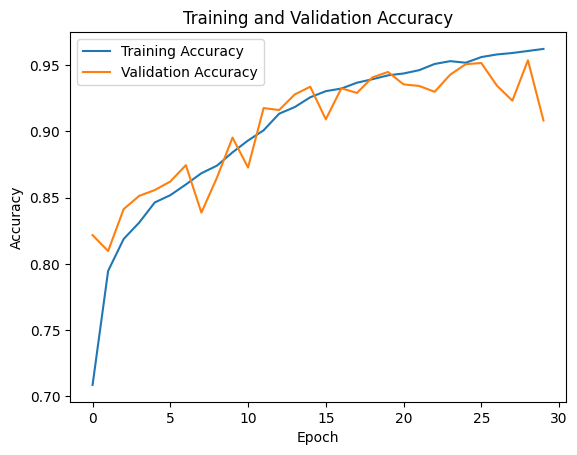

In [29]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
model_mod_lenet5.save('Mod_LeNet5.keras')